Using device: cuda


C:\Users\common47\AppData\Local\anaconda3\lib\site-packages\timm\models\_factory.py:117: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(
Epoch 1/5 - Training: 100%|██████████████████████████████████████████████████████████| 374/374 [26:46<00:00,  4.29s/it]


Epoch [1/5], Loss: 0.9985, Train Accuracy: 0.5914


Epoch 1/5 - Validation: 100%|██████████████████████████████████████████████████████████| 94/94 [06:31<00:00,  4.16s/it]


Epoch [1/5], Val Loss: 0.8390, Val Accuracy: 0.6822


Epoch 2/5 - Training: 100%|██████████████████████████████████████████████████████████| 374/374 [26:30<00:00,  4.25s/it]


Epoch [2/5], Loss: 0.7819, Train Accuracy: 0.7281


Epoch 2/5 - Validation: 100%|██████████████████████████████████████████████████████████| 94/94 [06:32<00:00,  4.18s/it]


Epoch [2/5], Val Loss: 0.7090, Val Accuracy: 0.7551


Epoch 3/5 - Training: 100%|██████████████████████████████████████████████████████████| 374/374 [26:34<00:00,  4.26s/it]


Epoch [3/5], Loss: 0.6722, Train Accuracy: 0.7747


Epoch 3/5 - Validation: 100%|██████████████████████████████████████████████████████████| 94/94 [06:20<00:00,  4.04s/it]


Epoch [3/5], Val Loss: 0.7223, Val Accuracy: 0.7611


Epoch 4/5 - Training: 100%|██████████████████████████████████████████████████████████| 374/374 [26:12<00:00,  4.21s/it]


Epoch [4/5], Loss: 0.6318, Train Accuracy: 0.7891


Epoch 4/5 - Validation: 100%|██████████████████████████████████████████████████████████| 94/94 [06:29<00:00,  4.14s/it]


Epoch [4/5], Val Loss: 0.6099, Val Accuracy: 0.7795


Epoch 5/5 - Training: 100%|██████████████████████████████████████████████████████████| 374/374 [26:36<00:00,  4.27s/it]


Epoch [5/5], Loss: 0.5781, Train Accuracy: 0.8036


Epoch 5/5 - Validation: 100%|██████████████████████████████████████████████████████████| 94/94 [06:05<00:00,  3.89s/it]


Epoch [5/5], Val Loss: 0.5968, Val Accuracy: 0.7862


Final Validation: 100%|████████████████████████████████████████████████████████████████| 94/94 [06:24<00:00,  4.09s/it]


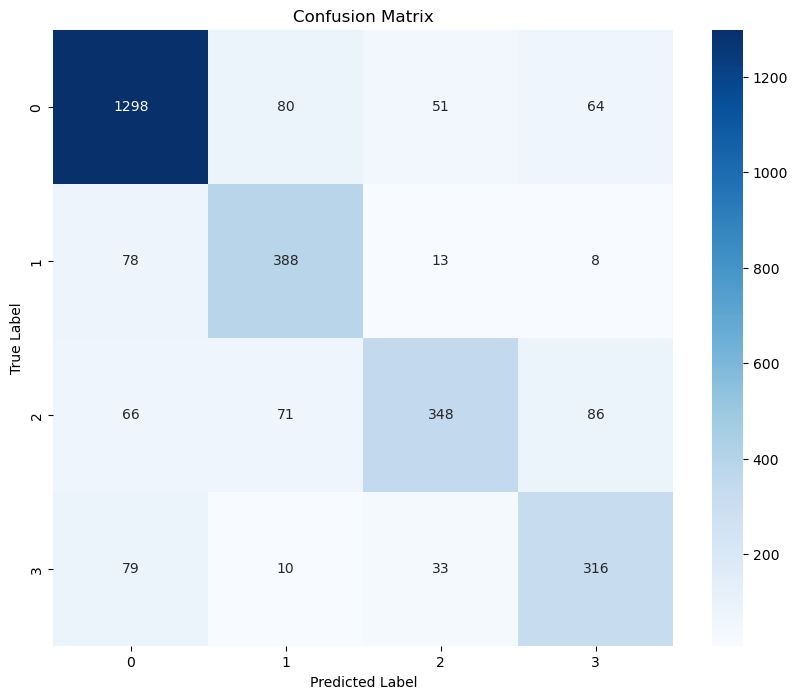

Accuracy: 0.7862
Precision: 0.7885
Recall: 0.7862
F1 Score: 0.7847


In [1]:
import os
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torchvision import transforms
from PIL import Image
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import timm

# Dataset class definition
class AccidentDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx, 0]
        image = Image.open(img_path).convert('RGB')
        label = self.data.iloc[idx, 1]

        if self.transform:
            image = self.transform(image)

        return image, label

# Preprocessing and data augmentation
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# CSV file path
csv_file = r"C:\Users\common47\Graduation\image_labels1.csv"

# Load dataset
dataset = AccidentDataset(csv_file, transform=transform)

# Split dataset into training and validation sets
train_idx, val_idx = train_test_split(np.arange(len(dataset)), test_size=0.2, random_state=42)
train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)

train_loader = DataLoader(dataset, batch_size=32, sampler=train_sampler)
val_loader = DataLoader(dataset, batch_size=32, sampler=val_sampler)

# Define the model
class XceptionLSTMClassifier(nn.Module):
    def __init__(self, num_classes, hidden_dim=128, lstm_layers=2, lstm_dropout=0.5):
        super(XceptionLSTMClassifier, self).__init__()
        self.cnn = timm.create_model('xception', pretrained=True)
        num_ftrs = self.cnn.get_classifier().in_features
        self.cnn.fc = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(num_ftrs, hidden_dim)
        )
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, lstm_layers, batch_first=True, dropout=lstm_dropout)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        if len(x.shape) == 5:
            batch_size, seq_length, c, h, w = x.size()
            cnn_out = []
            for t in range(seq_length):
                cnn_out.append(self.cnn(x[:, t, :, :, :]))

            cnn_out = torch.stack(cnn_out, dim=1)
            lstm_out, _ = self.lstm(cnn_out)
            lstm_out = lstm_out[:, -1, :]
            out = self.fc(lstm_out)
        elif len(x.shape) == 4:
            cnn_out = self.cnn(x)
            lstm_out, _ = self.lstm(cnn_out.unsqueeze(1))
            lstm_out = lstm_out[:, -1, :]
            out = self.fc(lstm_out)
        else:
            raise ValueError("Unsupported input shape")

        return out

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 모델 초기화 및 GPU로 이동
num_classes = 4  # 데이터셋에 맞게 조정
xception_lstm_model = XceptionLSTMClassifier(num_classes=num_classes)
xception_lstm_model = xception_lstm_model.to(device)

# 손실 함수 및 최적화 함수
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(xception_lstm_model.parameters(), lr=0.001)

# 모델 학습 및 검증
num_epochs = 5
for epoch in range(num_epochs):
    xception_lstm_model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs} - Training"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = xception_lstm_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_accuracy = correct / total
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}, Train Accuracy: {train_accuracy:.4f}")

    # 검증
    xception_lstm_model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Epoch {epoch + 1}/{num_epochs} - Validation"):
            images, labels = images.to(device), labels.to(device)
            outputs = xception_lstm_model(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_accuracy = val_correct / val_total
    print(f"Epoch [{epoch + 1}/{num_epochs}], Val Loss: {val_running_loss / len(val_loader):.4f}, Val Accuracy: {val_accuracy:.4f}")

# 최종 검증 및 성능 지표 계산
xception_lstm_model.eval()
all_labels = []
all_predictions = []

with torch.no_grad():
    for images, labels in tqdm(val_loader, desc="Final Validation"):
        images, labels = images.to(device), labels.to(device)
        outputs = xception_lstm_model(images)
        _, predicted = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Accuracy, Precision, Recall, F1 Score
accuracy = accuracy_score(all_labels, all_predictions)
precision = precision_score(all_labels, all_predictions, average='weighted')
recall = recall_score(all_labels, all_predictions, average='weighted')
f1 = f1_score(all_labels, all_predictions, average='weighted')

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
